### FigS1. noise correlation vs. signal correlation

In [ ]:
from util import fisherztrans,stat_m_e,pair_test,sig,color_inv_alpha
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import seaborn as sns
from faceprf_figure_function import set_figure,set_ax,myviolinplot_ind,myviolinplot_pair
import pingouin

cms=np.array([[255, 195, 73],[145, 115, 185]])/255

nsubj = 8
npos = 16
task = ['Digit Task','Face Task']
roi_labels = ['V1','V2','V3','hV4','IOG','pFus','mFus']
nroi = len(roi_labels)
ntask = len(task)

data_path = "../data/"

p(without correction):[0.576, 0.621, 0.0427, 0.0802, 0.0011, 0.0045, 0.0137]
p(correction):[1.0, 1.0, 0.2991, 0.5617, 0.008, 0.0318, 0.0962]


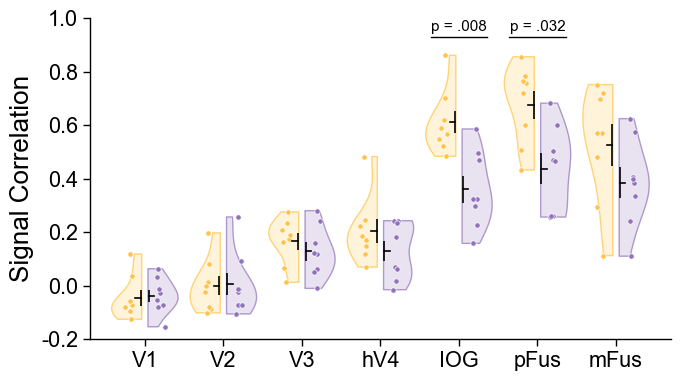

In [35]:
# signal correlation changes
signal_corr_all = np.load(data_path+'sig_corr.npz',allow_pickle=True)['signal_corr_all']
signal_corr_all[:,:,[0,1],:] = signal_corr_all[:,:,[1,0],:]
signal_corr = np.nanmedian(signal_corr_all,axis=0).transpose([2,0,1])

# test
signal_corr_fisherz = fisherztrans(signal_corr)
ps0,sts = pair_test(signal_corr_fisherz,method='ttest_rel',correction='none')
ps,sts = pair_test(signal_corr_fisherz,method='ttest_rel',correction='bonferroni')
print('p(without correction):{}'.format([round(p,4) for p in ps0]))
print('p(correction):{}'.format([round(p,4) for p in ps]))

# plot
set_figure()
fig,axes = plt.subplots(1,1,figsize=(7,4))
set_ax(axes)
myviolinplot_pair(axes,signal_corr,'mean','sem',ps,[0.94,0.93])
xlims = [0.3,7.7];ylims = [-0.2,1,0.2]
axes.set_ylabel('Signal Correlation',labelpad=5)
axes.set_xticklabels(roi_labels)
axes.set_yticks(np.arange(ylims[0],ylims[1]*1.01,ylims[2]))
axes.set_xlim(xlims)
axes.set_ylim(ylims[:2])
fig.savefig('figS1-signalcorr.pdf', bbox_inches='tight')

V1	anova	task:0.378	bin:0.000	interaction:0.007
                  Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        nc     
No. Observations:        64             Method:                    REML   
No. Groups:              8              Scale:                     0.0031 
Min. group size:         8              Log-Likelihood:            72.4843
Max. group size:         8              Converged:                 Yes    
Mean group size:         8.0                                              
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        0.139    0.028  4.969 0.000  0.084  0.194
cond_task[T.Face Task]          -0.022    0.023 -0.945 0.345 -0.068  0.024
cond_bin                         0.073    0.009  8.248 0.000  0.055  0.

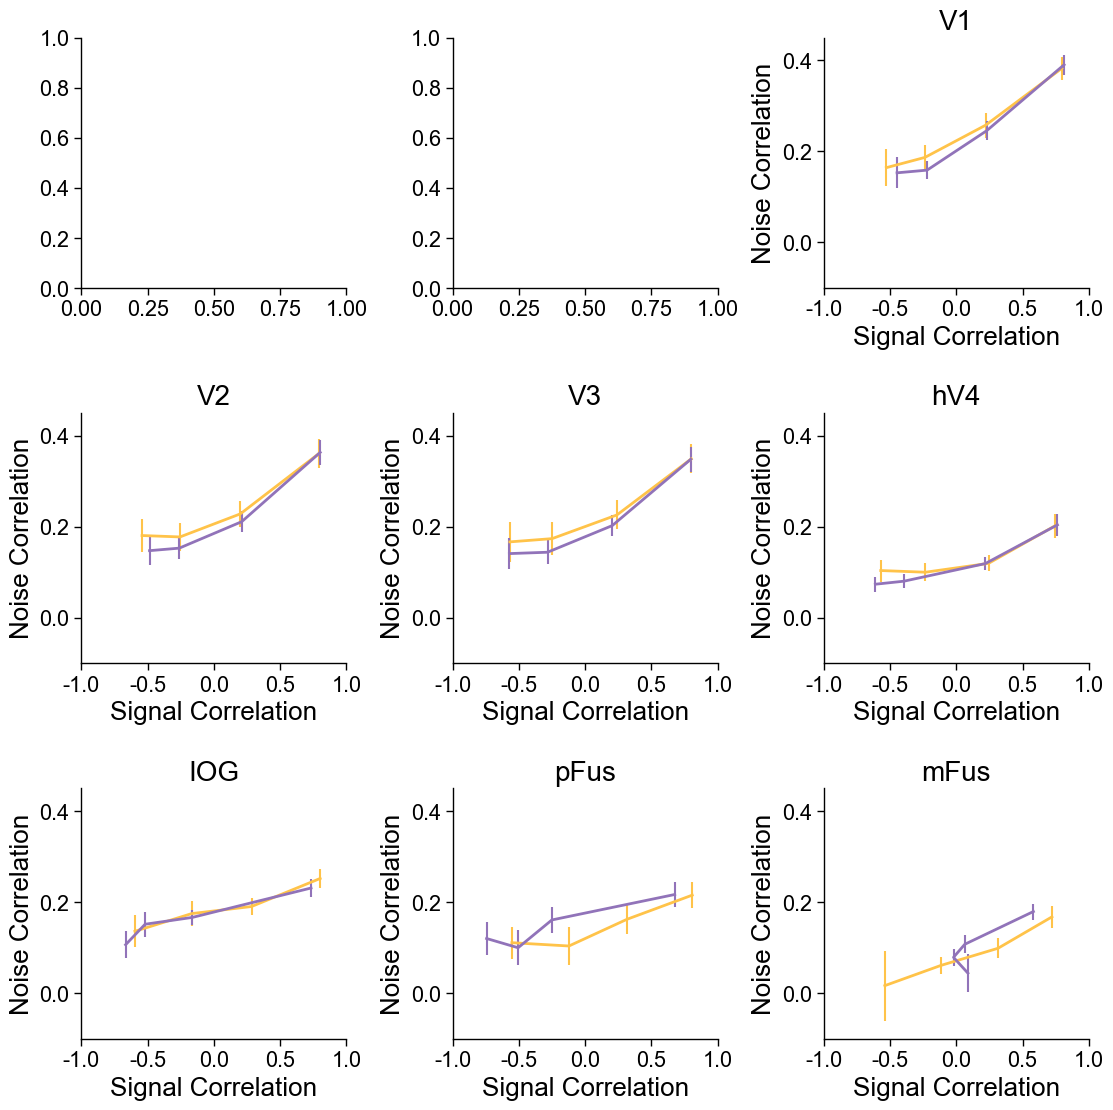

In [6]:
# voxelpairs x roi x task x subj
signal_corr_all = np.load(data_path+'sig_corr.npz',allow_pickle=True)['signal_corr_all']
noise_corr_all = np.load(data_path+'noise_corr.npz',allow_pickle=True)['noise_corr_all']
signal_corr_all[:,:,[0,1],:] = signal_corr_all[:,:,[1,0],:]
noise_corr_all[:,:,[0,1],:] = noise_corr_all[:,:,[1,0],:]

import warnings
warnings.simplefilter("ignore")
import statsmodels.api as sm
import statsmodels.formula.api as smf

bin_limits = np.arange(-1,1.01,0.5)
xbin = bin_limits[:-1]+0.25
set_figure()
fig,axes = plt.subplots(3,3,figsize=(13,13),sharex=False,sharey=False,gridspec_kw={'wspace': 0.4,'hspace': 0.5})
for roi_i in range(nroi):
    ax = axes[(roi_i+2)//3,(roi_i+2)%3]
    set_ax(ax)
    ps = np.zeros_like(xbin);ss = np.zeros_like(xbin)
    data_m = np.zeros([len(xbin),ntask])*np.nan
    data_e = np.zeros([2,len(xbin),ntask])*np.nan
    sc = np.ones([len(xbin),ntask,nsubj])*np.nan
    nc = np.ones([len(xbin),ntask,nsubj])*np.nan
    for bl in range(len(xbin)):
        scdata = signal_corr_all[:,roi_i,:,:]
        ncdata = noise_corr_all[:,roi_i,:,:]
        mask = (scdata[:,0,:]>bin_limits[bl]) & (scdata[:,0,:]<bin_limits[bl+1]) #digit
        sc[bl,:,:] = np.nanmedian(np.where(mask[:,np.newaxis,:],scdata,np.nan),axis=0)
        nc[bl,:,:] = np.nanmedian(np.where(mask[:,np.newaxis,:],ncdata,np.nan),axis=0)  
    # test
    data_forstats = pd.DataFrame({
        "subject" : np.tile(np.arange(nsubj),len(xbin)*ntask),
        "cond_task": np.tile(np.repeat(task,nsubj),len(xbin)),
        "cond_bin": np.repeat(np.arange(len(xbin)),nsubj*ntask),
        "nc":nc.flatten()
    })
    anova = pingouin.rm_anova(dv="nc",within=['cond_task','cond_bin'],subject="subject",data=data_forstats,detailed=True)
    print("{}\tanova\ttask:{:.3f}\tbin:{:.3f}\tinteraction:{:.3f}".format(roi_labels[roi_i],*np.array(anova['p-unc'])))
    '''
    if np.array(anova['p-unc'])[-1]<0.05:
        posthoc = np.array([pingouin.pairwise_ttests(data=data_forstats[data_forstats['cond_bin']==b],dv="nc",within="cond_task",subject="subject")['p-unc'].iloc[0] for b in range(4)])
        print("\tposthoc \t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}".format(*posthoc))
    '''
    data_forstats['cond_task'] = data_forstats['cond_task'].astype("category")
    data_forstats['subject'] = data_forstats['subject'].astype("category")
    df_clean = data_forstats.dropna()
    model = smf.mixedlm("nc ~ cond_task * cond_bin", df_clean, groups=df_clean["subject"], re_formula="~1")  # random intercept
    result = model.fit()
    print(result.summary())
    #print("\tlmm:\tintercept:{:.3f}\tcond_task:{:.3f}\tcond_bin:{:.3f}\tinteraction:{:.3f}".format(*np.array(result.pvalues)[:-1]))
    # plot
    data_m_nc = np.ones([len(xbin),ntask])*np.nan
    data_e_nc = np.ones([2,len(xbin),ntask])*np.nan
    data_m_sc = np.ones([len(xbin),ntask])*np.nan
    data_e_sc = np.ones([2,len(xbin),ntask])*np.nan
    for task_i in range(ntask):
        for bl in range(len(xbin)):
            [data_m_nc[bl,task_i],data_e_nc[:,bl,task_i],bsample] = stat_m_e(nc[bl,task_i,:],mtype='mean',etype='sem')  
            [data_m_sc[bl,task_i],data_e_sc[:,bl,task_i],bsample] = stat_m_e(sc[bl,task_i,:],mtype='mean',etype='sem')  
        ax.errorbar(data_m_sc[:,task_i], data_m_nc[:,task_i],data_e_nc[:,:,task_i],
                color=cms[task_i],marker='',ecolor=cms[task_i],elinewidth=1.5,capsize=0,capthick=1.5,linewidth=2,markersize=10)
    ax.set_title(roi_labels[roi_i],fontsize=20)    
    ax.set_xlim([-1,1])
    ax.set_xticks(bin_limits)
    ax.set_ylim([-0.1,0.45])
    ax.set_ylabel("Noise Correlation")
    ax.set_xlabel("Signal Correlation")
#fig.text(0.55, 0.5, 'Signal Correlation', va='center', rotation='horizontal',fontsize=20)
fig.savefig('figS1-sncorr.pdf', bbox_inches='tight')     

###